In [1]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import os
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

# for running through sublists
import random
from itertools import combinations


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the model

In [2]:
"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
torch.cuda.empty_cache()
model_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/"
model = gtu.load_model(model_path)
print('loaded!')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded!


In [3]:
# model

In [4]:
token_data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/resources/token_mapping.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,<pad>,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,<mask>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ENSG00000000003,2,TSPAN6,2.001186,15.0,protein_coding,X,100627107.0,100639991.0,False
3,ENSG00000000005,3,TNMD,3.228213,6.0,protein_coding,X,100584935.0,100599885.0,False
4,ENSG00000000419,4,DPM1,2.218874,14.0,protein_coding,20,50934866.0,50959140.0,False


# Load data

In [5]:
# See what we're working with (make sure we reload this in the next cell as the same thing)
df = gtu.load_data_as_dataframe("/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/no_induced_labeled_test.dataset")
df.head()
# df[df['cell_type'] == 'HSC']['cell_type'].value_counts()
# df[df['cell_type'] == 'fibroblast']['cell_type'].value_counts()

,input_ids,cell_type,dataset,length,ignore,label,broad_type,__index_level_0__
0,"[10265, 202, 3187, 2859, 6971, 1329, 4593, 100...",MPP,weng_young2_all,2048,MPP,5,stem/progenitor,33497
1,"[9512, 17163, 6816, 7086, 13125, 3187, 12924, ...",Refined.HSC,weng_young2_all,1796,Refined.HSC,13,stem/progenitor,38191
2,"[24210, 7188, 11347, 9508, 13509, 2551, 10479,...",endothelial cell,TS_Vasculature,1296,endothelial cell,15,endothelial,118365
3,"[16580, 4007, 4193, 3968, 9294, 11434, 12329, ...",ProB,weng_young2_all,1179,ProB,8,lymphoid,36008
4,"[20499, 2952, 10285, 6751, 13163, 7387, 331, 1...",erythrocyte,TS_Blood,203,erythrocyte,6,myeloid,212801


In [6]:

def load_data(path, sample_size=None):
    """
    Loads data from a file, processes cell types, and returns a DataFrame.

    Args:
        path (str): The path to the dataset file.
        sample_size (int, optional): Number of cells to sample. Defaults to None.
    Returns:
        pandas.DataFrame: The processed DataFrame.
    """

    df = gtu.load_data_as_dataframe(path)

    if "iHSC" in path:
        df['cell_type'] = "iHSC"
    elif "pellin" in path:
        df['cell_type'] = df['dataset']
    elif "weng" in path:
        df['cell_type'] = df['STD.CellType']
    else:
        df['cell_type'] = df['cell_type']

    #only adds dataset column and sets it to be based on the path name if it DOESN'T ALREADY EXIST
    #it does exist for some of the stuff we deal with
    if 'dataset' not in df.columns:
        df['dataset'] = os.path.splitext(os.path.basename(path))[0]
    
    df = df[['input_ids', 'cell_type', 'dataset', 'length']]
    return df

def add_sequential_id(df):
    """Adds a new column named 'id' with sequential identifiers starting from 1.

    Args:
        df (pandas.DataFrame): The DataFrame to add the 'id' column to.

    Returns:
        pandas.DataFrame: The DataFrame with the added 'id' column.
    """
    df['cell_id'] = range(1, len(df) + 1)
    df['cell_id'] = "cell_" + df['cell_id'].astype(str)
    return df

data_paths = [
    # "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/iHSC.dataset",   
    # "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset",   
    # "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/weng_young2_HSC.dataset",
    "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/no_induced_labeled_test.dataset"


]
print("Checkpoint!")

#why does adding this not change anything, it should!
#sample_size = 1000

df = []

for path in data_paths:
    tmp = load_data(path)
    df.append(tmp)
    
df = pd.concat(df)
df = add_sequential_id(df)
print(f"{df.shape=}")


# make sure that sample size > num_fibro + num_hsc
num_fibro = 300
num_hsc = 200

# Filter and sample each cell type separately
fibroblast_df = df[df['cell_type'] == 'fibroblast'].sample(n=num_fibro, random_state=1)
hsc_df = df[df['cell_type'] == 'HSC'].sample(n=num_hsc, random_state=1)

reprog_df = pd.concat([fibroblast_df, hsc_df])

print(f"{reprog_df.shape=}")


df.head()
data = Dataset.from_pandas(reprog_df)



# dated, fixes total amount and leaves types random
#besides, fibroblast is lowercase in this dataset
#reprog_df = df[df['cell_type'].isin(['Fibroblast', 'HSC'])]
# reprog_df = df[df['cell_type'].isin(['Fibroblast', 'HSC'])].sample(n=500, random_state=1)

Checkpoint!
df.shape=(61843, 5)
reprog_df.shape=(500, 5)


In [7]:
reprog_df.head()

,input_ids,cell_type,dataset,length,cell_id
46487,"[18367, 12119, 6541, 16876, 16916, 2124, 8261,...",fibroblast,TS_Vasculature,2048,cell_46488
59711,"[376, 3878, 1732, 1404, 16916, 5080, 6541, 183...",fibroblast,TS_Vasculature,2048,cell_59712
24292,"[1950, 9009, 3878, 16916, 16876, 12119, 8447, ...",fibroblast,TS_Vasculature,2048,cell_24293
26313,"[12119, 16916, 5592, 16876, 8529, 1404, 9009, ...",fibroblast,TS_Vasculature,2048,cell_26314
37358,"[9009, 16876, 10753, 16916, 10057, 18367, 9686...",fibroblast,TS_Vasculature,2048,cell_37359


In [8]:
print(reprog_df['cell_type'].value_counts())

cell_type
fibroblast    300
HSC           200
Name: count, dtype: int64


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]
/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [46487, 59711, 24292, 26313, 37358]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


embs.shape=(500, 512)


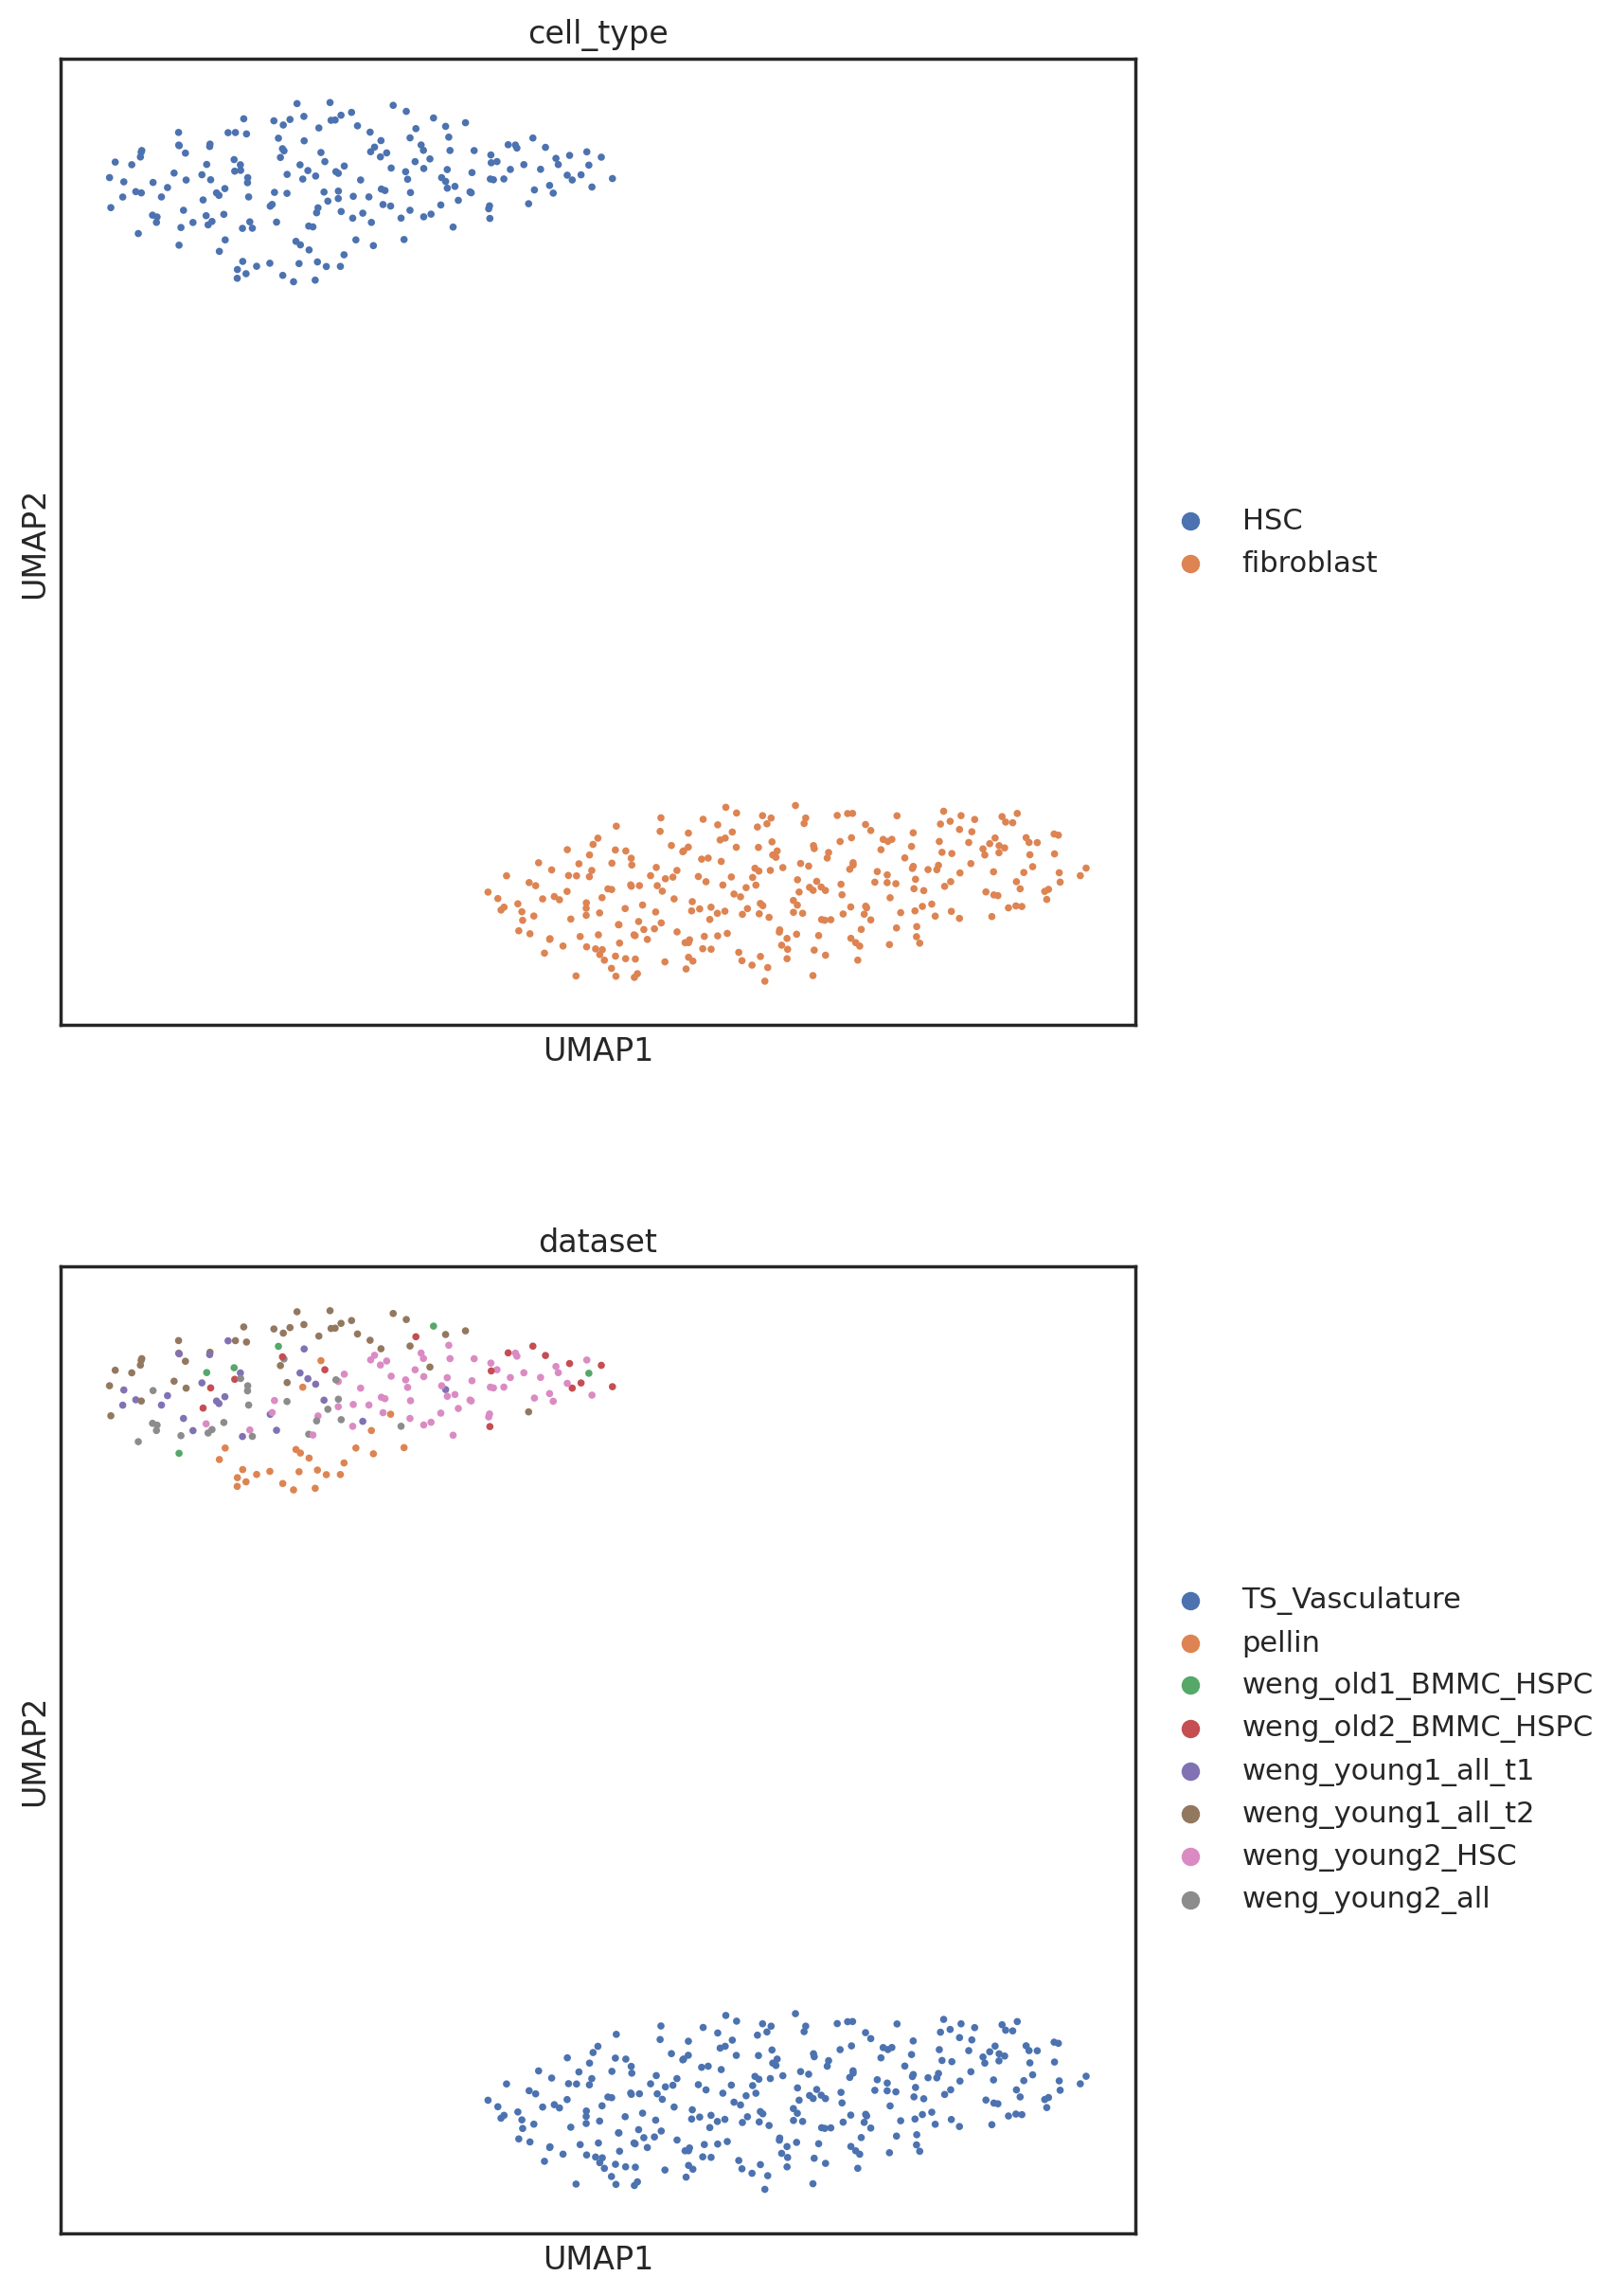

AnnData object with n_obs × n_vars = 500 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'cell_id'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)

print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = reprog_df.copy()

sc.tl.pca(adata, n_comps=25)
sc.pp.neighbors(adata, n_neighbors=200)
sc.tl.umap(adata, 
           min_dist=0.75,
          )

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sc.pl.umap(
    adata,
    color=["cell_type", "dataset"],
    ncols=1,
    size=30,
)

adata

# Clean up cell types

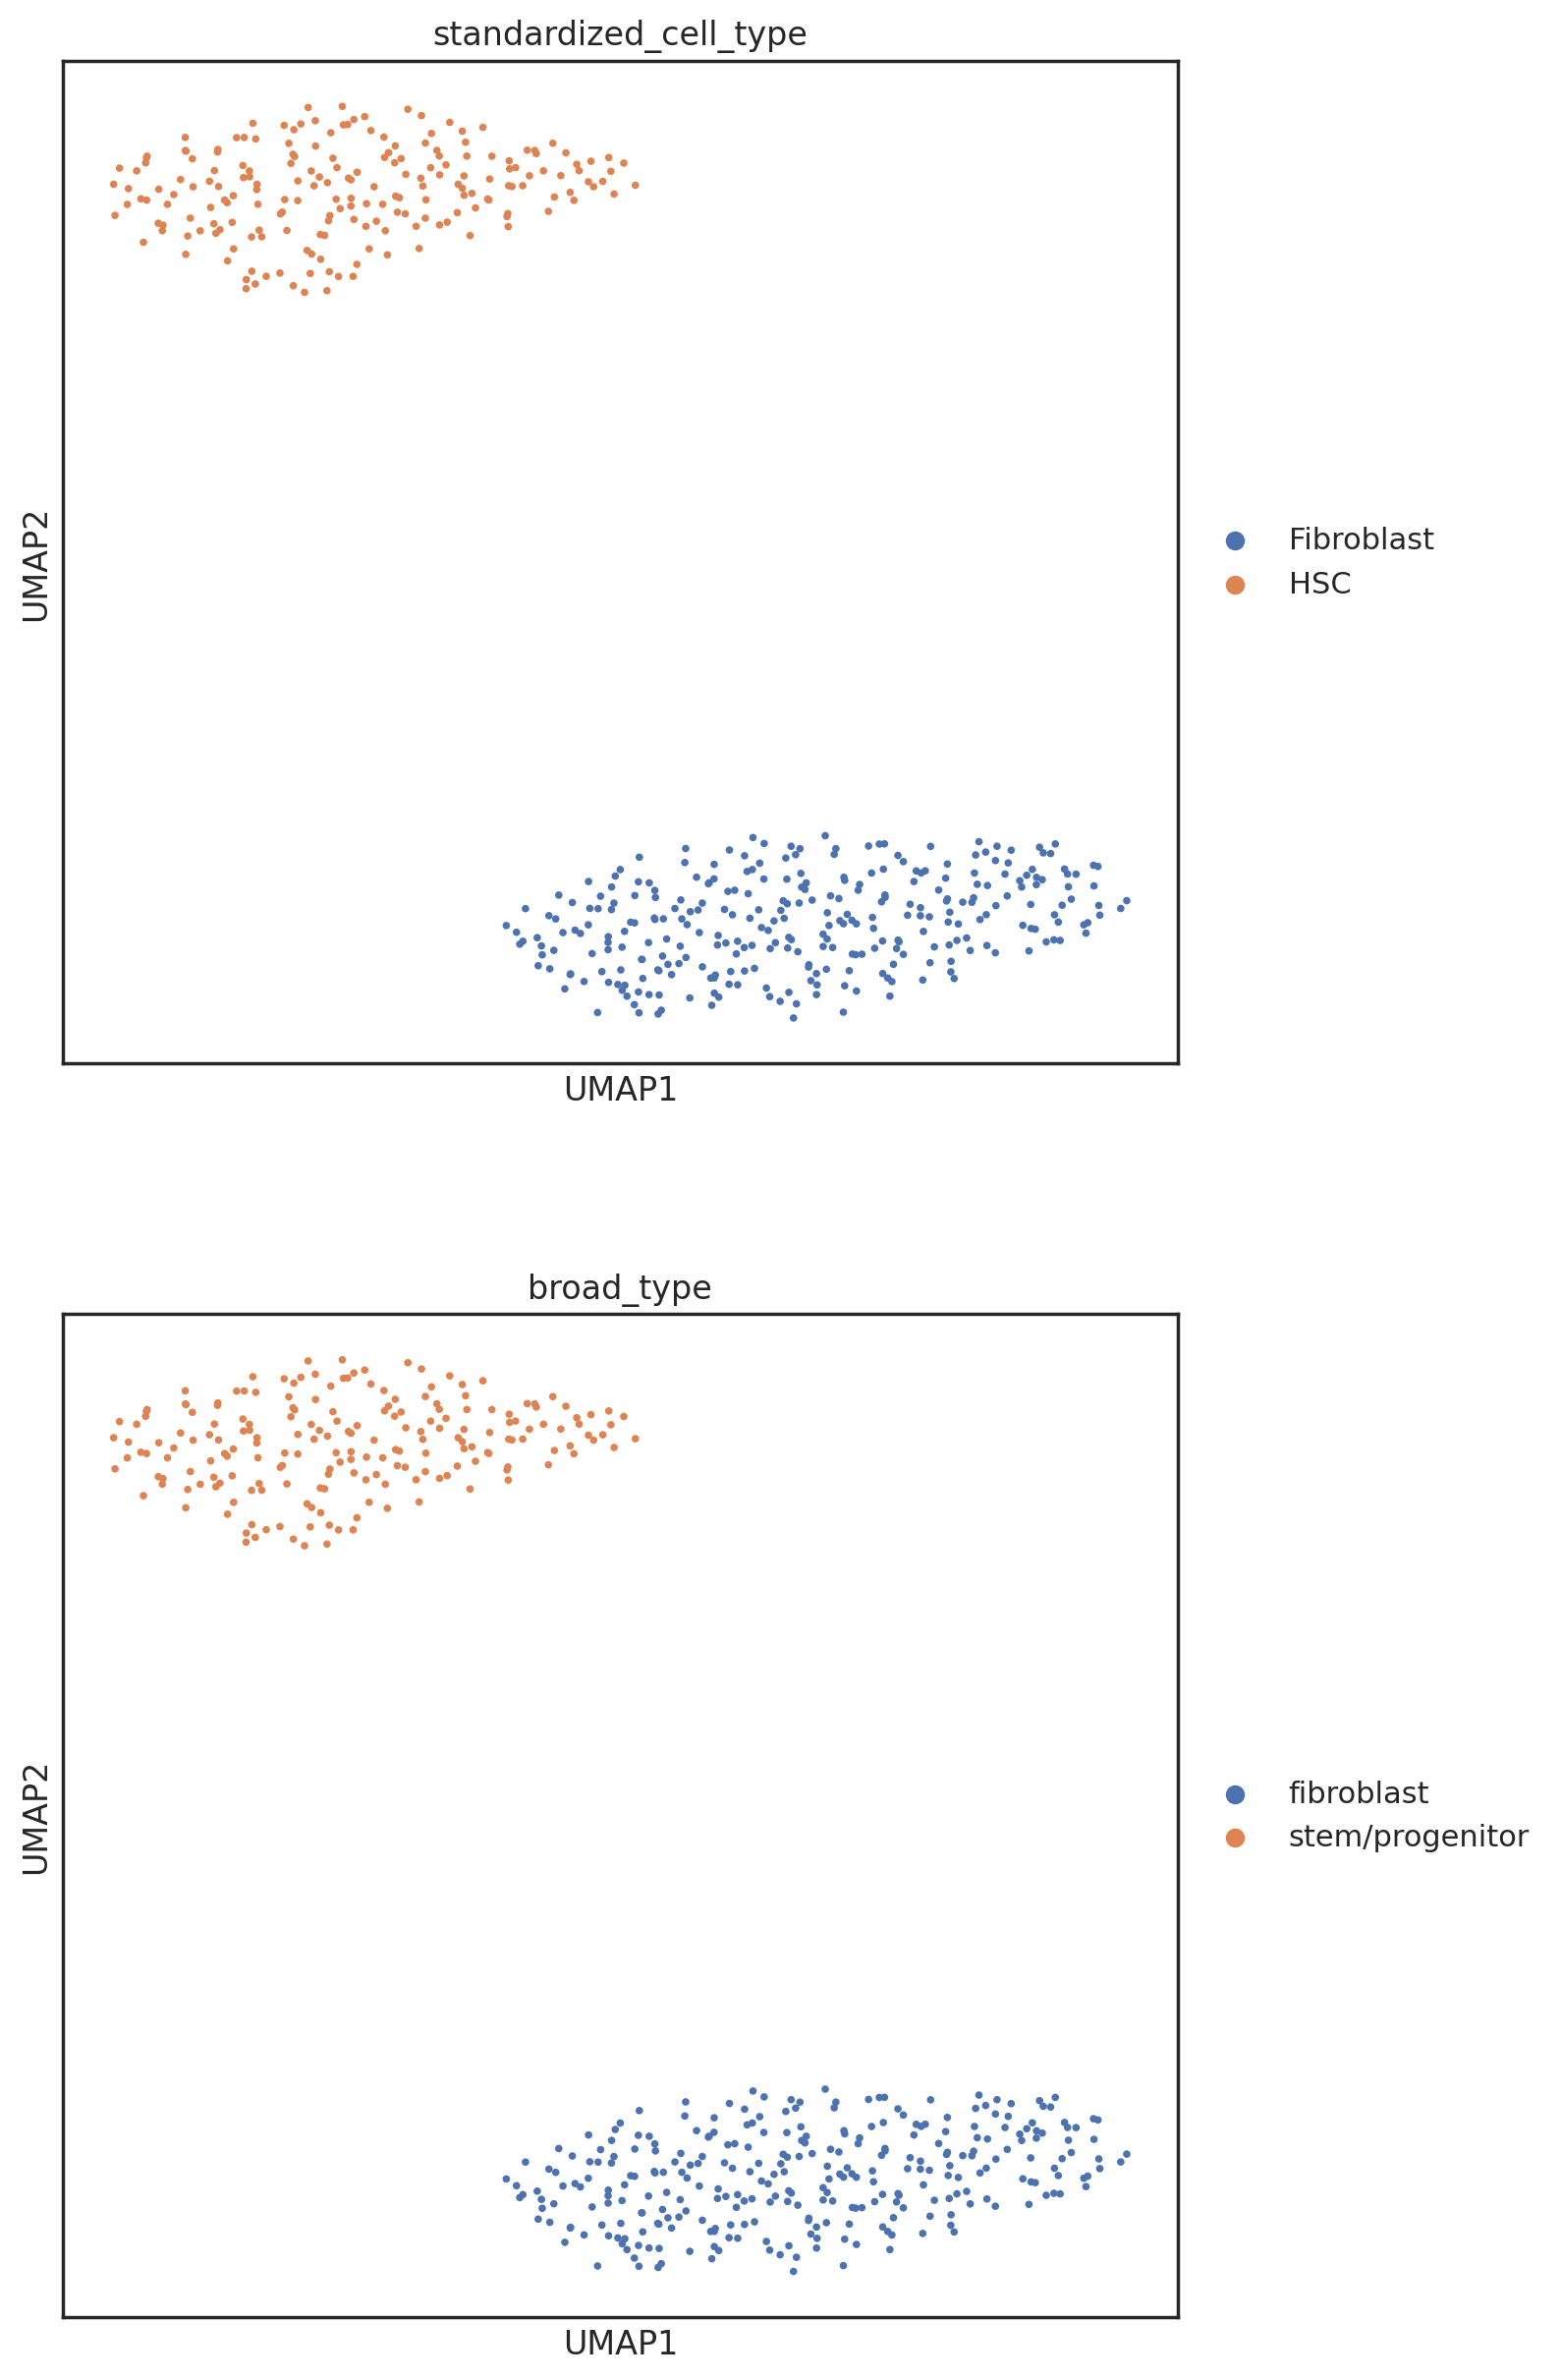

In [10]:
fpath = "ihsc_cell_types.csv"
cell_map = pd.read_csv(fpath, comment="#")

adata.obs = pd.merge(adata.obs, 
                     cell_map,
                     how='left',
                     left_on='cell_type',
                     right_on='label',
                    )

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7
sc.pl.umap(
    adata,
    color=["standardized_cell_type","broad_type"],
    ncols=1,
    size=30,
)

In [11]:
reprog_df[reprog_df['dataset'] == "pellin"]['cell_type'].value_counts()

cell_type
HSC    26
Name: count, dtype: int64

# COMPUTE HSC CENTROID

In [12]:
HSC_embeddings = adata[adata.obs['cell_type'] == 'HSC', :].X
hsc_cenroid = HSC_embeddings.mean(axis=0)
hsc_cenroid = hsc_cenroid.reshape(1, -1)
print(f"{hsc_cenroid.shape=}")

hsc_cenroid.shape=(1, 512)


In [13]:
#replaces the get_gene_tokens from some other files
tfs = [
    "GATA2",
    "GFI1B",
    "FOS",
    "STAT5A",
    "REL",
    "FOSB",
    "IKZF1",
    "RUNX3",
    "MEF2C",
    "ETV6"
]


In [14]:

def get_gene_tokens(token_df, gene_names):
    """
    Extracts the token IDs of specified genes from a DataFrame.

    Args:
      token_df (pandas.DataFrame): The DataFrame containing gene information.
      gene_names (list): A list of gene names to extract.

    Returns:
      list: A list of token IDs corresponding to the specified genes.
    """
    genes = token_df[token_df['gene_name'].isin(gene_names)]
    return genes['token_id'].to_list()

# Not calling this because we actually want to call it on sublists later!
# tf_tokens = get_gene_tokens(token_df, tfs)token_df[token_df['gene_name'].isin(tfs)]['token_id'].to_list()
# print(tf_tokens)

# Perturb the Data (One perturbation) - Do Not Run!

### This code includes copies of functions in the next section, as they are meant to entirely stand alone. 
### Variable names are repeated. Do not run both at the same time.

In [15]:
#break

In [16]:
# def perturb_data(df, tokens):
#     """
#     Perturbs the input_ids in a DataFrame by prepending a list of tokens.

#     Args:
#       df (pandas.DataFrame): The input DataFrame with an 'input_ids' column.
#       tokens (list): The list of tokens to prepend.

#     Returns:
#       pandas.DataFrame: The combined DataFrame with original and perturbed data.
#     """

#     perturbed = df.copy()
#     perturbed['state'] = 'perturbed'
#     perturbed['input_ids'] = perturbed['input_ids'].apply(
#       lambda x: list(tokens) + list(x)[:len(x) - len(tokens)]
#     )

#     df['state'] = 'raw'
#     combined_df = pd.concat([df, perturbed])
#     return combined_df

# sample_size = 400
# fb_cells = adata.obs[adata.obs['cell_type'] == 'Fibroblasts'].copy()
# fb_cells = fb_cells.sample(sample_size)
# fb_cells = fb_cells.reset_index(names='cell_id')
# fb_cells.head()

# perturbed = perturb_data(fb_cells, tf_tokens)
# perturbed = perturbed.reset_index(drop=True)
# perturbed_data = Dataset.from_pandas(perturbed)

# # extract the embeddings
# torch.cuda.empty_cache()
# test_embs = gtu.extract_embedding_in_mem(model, perturbed_data, layer_to_quant=-1)

# perturbed



In [17]:
# # testing to make sure that there are multiple of a certain cell id, with one raw and one perturbed
# #since above are randomly selected cells, you'll have to change this
# # we expect either 0 or 2. anything else is wrong.
# # Check the data type of the 'cell_id' column
# print(perturbed['cell_id'].dtype)

# # Convert the 'cell_id' column to string type (if needed)
# perturbed['cell_id'] = perturbed['cell_id'].astype(str)

# # Strip any leading or trailing whitespace from the 'cell_id' column
# perturbed['cell_id'] = perturbed['cell_id'].str.strip()

# # Check the number of rows with the specific value in the 'cell_id' column
# num_rows = perturbed[perturbed['cell_id'] == '411'].shape[0]
# print(num_rows)

In [18]:
#break

# Perturb the Data (Loop thru Sublists)

In [19]:
def perturb_data(df, tokens):
    """
    Perturbs the input_ids in a DataFrame by prepending a list of tokens.

    Args:
      df (pandas.DataFrame): The input DataFrame with an 'input_ids' column.
      tokens (list): The list of tokens to prepend.

    Returns:
      pandas.DataFrame: The combined DataFrame with original and perturbed data.
    """

    perturbed = df.copy()
    perturbed['state'] = 'perturbed'
    perturbed['input_ids'] = perturbed['input_ids'].apply(
      lambda x: list(tokens) + list(x)[:len(x) - len(tokens)]
    )

    df['state'] = 'raw'
    combined_df = pd.concat([df, perturbed])
    return combined_df

In [20]:
# Filter down dataframe once more to only include sample_size - many randomly selected fibroblasts

sample_size = 10
fb_cells = adata.obs[adata.obs['cell_type'] == 'fibroblast'].copy()
fb_cells = fb_cells.sample(sample_size)
fb_cells = fb_cells.reset_index(names='xtra_cell_id')
fb_cells.head()


,xtra_cell_id,input_ids,cell_type,dataset,length,cell_id,label,standardized_cell_type,broad_type
0,28,"[16916, 9009, 1950, 16876, 3878, 18367, 8654, ...",fibroblast,TS_Vasculature,2048,cell_29100,fibroblast,Fibroblast,fibroblast
1,32,"[7414, 1732, 4591, 5675, 3304, 3878, 11825, 16...",fibroblast,TS_Vasculature,2048,cell_28811,fibroblast,Fibroblast,fibroblast
2,288,"[12304, 1950, 11350, 3584, 454, 9009, 376, 151...",fibroblast,TS_Vasculature,2048,cell_4236,fibroblast,Fibroblast,fibroblast
3,278,"[18367, 12119, 10057, 3034, 2124, 9123, 16916,...",fibroblast,TS_Vasculature,2048,cell_14905,fibroblast,Fibroblast,fibroblast
4,153,"[16916, 15960, 12119, 9009, 16876, 3878, 8529,...",fibroblast,TS_Vasculature,2048,cell_22845,fibroblast,Fibroblast,fibroblast


In [21]:
# Get every sublist of the perturbation list
# problem: sublist column doesnt exist here

# gene_sublists = [list(comb) for comb in combinations(tfs, 5)]

# # used to be called all_sampled_data
# perturbed = []

# for sublist in gene_sublists:
#     sublist_tokens = get_gene_tokens(token_df, sublist)
#     pdf = perturb_data(reprog_df, sublist_tokens)
#     print(pdf.columns)
#     # Sample n random cells from the perturbed data
#     sampled_pdf = pdf[pdf['sublist'] != 'raw'].sample(n=10, random_state=1)
#     perturbed.append(sampled_pdf)
#     print("appended ", sublist)

# perturbed = perturbed.reset_index(drop=True)
# perturbed_data = Dataset.from_pandas(perturbed)

# perturbed

In [21]:


# Get every sublist of the perturbation list
gene_sublists = [list(comb) for comb in combinations(tfs, 5)]

#add a new col for state and a new col for 
fb_cells['state'] = 'raw'
fb_cells['sublist'] = pd.NA

# List to hold all dataframes including raw data and perturbed data
all_sampled_data = []

# Process each sublist
for sublist in gene_sublists:
    sublist_tokens = get_gene_tokens(token_df, sublist)
    
    for _, row in fb_cells.iterrows():
        cell_df = pd.DataFrame([row])
        pdf = perturb_data(cell_df, sublist_tokens)
        
        # Update the 'sublist' and 'state' columns
        pdf['sublist'] = str(sublist)
        pdf['state'] = 'perturbed'
        
        all_sampled_data.append(pdf)
        print("appended perturbation for sublist", sublist)

# Concatenate all sampled data into one DataFrame
perturbed_df = pd.concat(all_sampled_data).reset_index(drop=True)

# Concatenate the raw data and perturbed data
final_sampled_data = pd.concat([fb_cells, perturbed_df]).reset_index(drop=True)
print(f"Final sampled DataFrame shape: {final_sampled_data.shape}")

# Process df
data = Dataset.from_pandas(final_sampled_data)
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)

# Translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = final_sampled_data.copy()


appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'FOSB']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'FOSB']
appended perturbation for sublist ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'FOS

100%|██████████| 505/505 [02:15<00:00,  3.73it/s]


In [81]:

# #get every sublist of the perturbation list
# gene_sublists = [list(comb) for length in range(1, 6) for comb in combinations(gene_names, length)]
# all_sampled_data = []

# for sublist in gene_sublists:
#     sublist_tokens = get_gene_tokens(token_df, sublist)
#     pdf = perturb_data(reprog_df, sublist_tokens, sublist)
    
#     # Sample 100 random cells from the perturbed data
#     sampled_pdf = pdf[pdf['sublist'] != 'raw'].sample(n=10, random_state=1)
#     all_sampled_data.append(sampled_pdf)
#     print("appended ", sublist)

# # Concatenate all sampled data into one DataFrame
# final_sampled_data = pd.concat(all_sampled_data).reset_index(drop=True)
# print(f"Final sampled DataFrame shape: {final_sampled_data.shape}")

# # process df
# data = Dataset.from_pandas(final_sampled_data)
# embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
# # Translate into an anndata object and plot
# adata = gtu.embedding_to_adata(embs)
# adata.obs = final_sampled_data.copy()






















# # Get every sublist of the perturbation list
# gene_sublists = [list(comb) for comb in combinations(tfs, 5)]

# perturbed = []

# for sublist in gene_sublists:
#     sublist_tokens = get_gene_tokens(token_df, sublist)
#     pdf = perturb_data(reprog_df, sublist_tokens)
    
#     # Add a new column 'sublist' with the current sublist as its value
#     pdf['sublist'] = str(sublist)
    
#     # Sample n random cells from the perturbed data?
#     # Hashtag no thanks, thats random af and we can filter by what we want earlier
#     # sampled_pdf = pdf.sample(n=10, random_state=1)
    
#     perturbed.append(pdf)
#     print("appended ", sublist)

# # Concatenate the list of DataFrames
# perturbed_df = pd.concat(perturbed).reset_index(drop=True)

# # Create a Dataset from the perturbed DataFrame
# perturbed_data = Dataset.from_pandas(perturbed_df)


appended  ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
appended  ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'FOSB']
appended  ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'IKZF1']
appended  ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'RUNX3']
appended  ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'MEF2C']
appended  ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'ETV6']
appended  ['GATA2', 'GFI1B', 'FOS', 'REL', 'FOSB']
appended  ['GATA2', 'GFI1B', 'FOS', 'REL', 'IKZF1']
appended  ['GATA2', 'GFI1B', 'FOS', 'REL', 'RUNX3']
appended  ['GATA2', 'GFI1B', 'FOS', 'REL', 'MEF2C']
appended  ['GATA2', 'GFI1B', 'FOS', 'REL', 'ETV6']
appended  ['GATA2', 'GFI1B', 'FOS', 'FOSB', 'IKZF1']
appended  ['GATA2', 'GFI1B', 'FOS', 'FOSB', 'RUNX3']
appended  ['GATA2', 'GFI1B', 'FOS', 'FOSB', 'MEF2C']
appended  ['GATA2', 'GFI1B', 'FOS', 'FOSB', 'ETV6']
appended  ['GATA2', 'GFI1B', 'FOS', 'IKZF1', 'RUNX3']
appended  ['GATA2', 'GFI1B', 'FOS', 'IKZF1', 'MEF2C']
appended  ['GATA2', 'GFI1B', 'FOS', 'IKZF1', 'ETV6']
appended  ['GATA2', 'GFI1B', 'FOS', 'RUNX3',

,input_ids,cell_type,dataset,length,cell_id,state,sublist
0,"[18367, 12119, 6541, 16876, 16916, 2124, 8261,...",fibroblast,TS_Vasculature,2048,cell_46488,raw,"['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']"
1,"[376, 3878, 1732, 1404, 16916, 5080, 6541, 183...",fibroblast,TS_Vasculature,2048,cell_59712,raw,"['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']"
2,"[1950, 9009, 3878, 16916, 16876, 12119, 8447, ...",fibroblast,TS_Vasculature,2048,cell_24293,raw,"['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']"
3,"[12119, 16916, 5592, 16876, 8529, 1404, 9009, ...",fibroblast,TS_Vasculature,2048,cell_26314,raw,"['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']"
4,"[9009, 16876, 10753, 16916, 10057, 18367, 9686...",fibroblast,TS_Vasculature,2048,cell_37359,raw,"['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']"


In [22]:
perturbed_df.sample(10)

,xtra_cell_id,input_ids,cell_type,dataset,length,cell_id,label,standardized_cell_type,broad_type,state,sublist
1771,182,"[404, 7725, 12698, 14409, 15641, 16916, 3878, ...",fibroblast,TS_Vasculature,2048,cell_56971,fibroblast,Fibroblast,fibroblast,perturbed,"['GATA2', 'FOS', 'IKZF1', 'RUNX3', 'ETV6']"
3310,182,"[16916, 3878, 9009, 1720, 4115, 10292, 19437, ...",fibroblast,TS_Vasculature,2048,cell_56971,fibroblast,Fibroblast,fibroblast,perturbed,"['GFI1B', 'STAT5A', 'REL', 'IKZF1', 'RUNX3']"
695,19,"[404, 5806, 7725, 11599, 14409, 3878, 1950, 37...",fibroblast,TS_Vasculature,2048,cell_4531,fibroblast,Fibroblast,fibroblast,perturbed,"['GATA2', 'GFI1B', 'STAT5A', 'RUNX3', 'ETV6']"
4780,28,"[16916, 9009, 1950, 16876, 3878, 18367, 8654, ...",fibroblast,TS_Vasculature,2048,cell_29100,fibroblast,Fibroblast,fibroblast,perturbed,"['STAT5A', 'REL', 'IKZF1', 'MEF2C', 'ETV6']"
4206,278,"[18367, 12119, 10057, 3034, 2124, 9123, 16916,...",fibroblast,TS_Vasculature,2048,cell_14905,fibroblast,Fibroblast,fibroblast,perturbed,"['FOS', 'STAT5A', 'FOSB', 'RUNX3', 'ETV6']"
821,28,"[1532, 10804, 11599, 14409, 15641, 16916, 9009...",fibroblast,TS_Vasculature,2048,cell_29100,fibroblast,Fibroblast,fibroblast,perturbed,"['GATA2', 'GFI1B', 'REL', 'IKZF1', 'MEF2C']"
4042,32,"[7414, 1732, 4591, 5675, 3304, 3878, 11825, 16...",fibroblast,TS_Vasculature,2048,cell_28811,fibroblast,Fibroblast,fibroblast,perturbed,"['FOS', 'STAT5A', 'REL', 'IKZF1', 'ETV6']"
2506,278,"[18367, 12119, 10057, 3034, 2124, 9123, 16916,...",fibroblast,TS_Vasculature,2048,cell_14905,fibroblast,Fibroblast,fibroblast,perturbed,"['GATA2', 'IKZF1', 'RUNX3', 'MEF2C', 'ETV6']"
212,68,"[9190, 5716, 16916, 5592, 6715, 15960, 3878, 1...",fibroblast,TS_Vasculature,2048,cell_41492,fibroblast,Fibroblast,fibroblast,perturbed,"['GATA2', 'GFI1B', 'FOS', 'REL', 'ETV6']"
1593,68,"[404, 7725, 10804, 12698, 14409, 9190, 5716, 1...",fibroblast,TS_Vasculature,2048,cell_41492,fibroblast,Fibroblast,fibroblast,perturbed,"['GATA2', 'FOS', 'REL', 'RUNX3', 'ETV6']"


In [ ]:
break

# Compute Distance to HSC

In [27]:
# Distance from perturbed to centroid


metric = 'cosine'
Xa = embs.to_numpy()
Xb = hsc_cenroid

print(f"{Xa.shape=} {Xb.shape=}")
D = cdist(Xa, Xb, metric=metric)
print(f"{D.shape=}")



final_sampled_data['distance_to_hsc'] = D.ravel()
final_sampled_data


# D

Xa.shape=(5050, 512) Xb.shape=(1, 512)
D.shape=(5050, 1)


,xtra_cell_id,input_ids,cell_type,dataset,length,cell_id,label,standardized_cell_type,broad_type,state,sublist,distance_to_hsc
0,28,"[16916, 9009, 1950, 16876, 3878, 18367, 8654, ...",fibroblast,TS_Vasculature,2048,cell_29100,fibroblast,Fibroblast,fibroblast,raw,NaN,0.895132
1,32,"[7414, 1732, 4591, 5675, 3304, 3878, 11825, 16...",fibroblast,TS_Vasculature,2048,cell_28811,fibroblast,Fibroblast,fibroblast,raw,NaN,0.895747
2,288,"[12304, 1950, 11350, 3584, 454, 9009, 376, 151...",fibroblast,TS_Vasculature,2048,cell_4236,fibroblast,Fibroblast,fibroblast,raw,NaN,0.801326
3,278,"[18367, 12119, 10057, 3034, 2124, 9123, 16916,...",fibroblast,TS_Vasculature,2048,cell_14905,fibroblast,Fibroblast,fibroblast,raw,NaN,0.886414
4,153,"[16916, 15960, 12119, 9009, 16876, 3878, 8529,...",fibroblast,TS_Vasculature,2048,cell_22845,fibroblast,Fibroblast,fibroblast,raw,NaN,0.869567
...,...,...,...,...,...,...,...,...,...,...,...,...
5045,19,"[404, 1532, 5675, 7725, 15641, 3878, 1950, 376...",fibroblast,TS_Vasculature,2048,cell_4531,fibroblast,Fibroblast,fibroblast,perturbed,"['FOSB', 'IKZF1', 'RUNX3', 'MEF2C', 'ETV6']",0.844038
5046,171,"[376, 2649, 10945, 8981, 8251, 11411, 11028, 1...",fibroblast,TS_Vasculature,2048,cell_50526,fibroblast,Fibroblast,fibroblast,perturbed,"['FOSB', 'IKZF1', 'RUNX3', 'MEF2C', 'ETV6']",0.853424
5047,171,"[404, 1532, 5675, 7725, 15641, 376, 2649, 1094...",fibroblast,TS_Vasculature,2048,cell_50526,fibroblast,Fibroblast,fibroblast,perturbed,"['FOSB', 'IKZF1', 'RUNX3', 'MEF2C', 'ETV6']",0.815901
5048,62,"[9009, 16916, 1950, 15960, 3878, 5592, 16876, ...",fibroblast,TS_Vasculature,2048,cell_36080,fibroblast,Fibroblast,fibroblast,perturbed,"['FOSB', 'IKZF1', 'RUNX3', 'MEF2C', 'ETV6']",0.852062


# Compute distance between raw and perturbed states

In [ ]:
P = squareform(pdist(Xa, metric=metric))
print(f"{P.shape=}")
print(P)

In [ ]:
result = []

for cell_id, group in perturbed.groupby('cell_id'):
    idx = group.index.to_list()
    
    raw_row = group.iloc[0]
    perturbed_row = group.iloc[1]

    row = {
        'cell_id' : cell_id,
        'raw_to_hsc' : raw_row['distance_to_hsc'],
        'perturbed_to_hsc' : perturbed_row['distance_to_hsc'],
        'raw_to_perturbed' : P[idx[0], idx[1]],
    }
    
    result.append(row)
    
result = pd.DataFrame(result)
result.head()

In [ ]:
plt.rcParams['figure.dpi'] = 75
sns.histplot(data=result, 
             x='raw_to_hsc')

In [ ]:
plt.rcParams['figure.dpi'] = 75
sns.histplot(data=result, 
             x='perturbed_to_hsc')

In [ ]:
plt.rcParams['figure.dpi'] = 75
sns.histplot(data=result, 
             x='raw_to_perturbed')

In [ ]:
break